# Grid-related Climate Change Impact per kWh Electricity

## Electricity generation impacts


In [2]:
import bw2data as bd
import bw2calc as bc

In [3]:
bd.projects.set_current("bw25_ei310_premise2.3.0dev1_new")

In [4]:
method = ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')

In [5]:
mixes = [act for act in bd.Database("new_mixes") if act["name"].startswith("market group for electricity, low voltage")]

In [6]:
scores = {}
for act in mixes:
    lca = bc.LCA({act: 1}, method=method)
    lca.lci()
    lca.lcia()
    scores[act["name"]] = lca.score

/Users/timodiepers/anaconda3/envs/paper-plca-grid-expansion/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.53e+13)
  warnings.warn(msg, UmfpackWarning)


In [7]:
scenario_mapping = {
    "market group for electricity, low voltage DE 2023 SS2_NPi NO GRID": "statusquo",
    "market group for electricity, low voltage DE 2045 SSP2-PkBudg650 NO GRID": "PkBudg650",
    "market group for electricity, low voltage DE 2045 SSP2-PkBudg1000 NO GRID": "PkBudg1000",
    "market group for electricity, low voltage DE 2045 SSP2_NPi NO GRID": "NPi",
}

In [8]:
electricity_generation_impacts = {
    scenario_mapping[key]: val for key, val in scores.items()
}

electricity_generation_impacts["static_expansion"] = electricity_generation_impacts[
    "statusquo"
]

electricity_generation_impacts  # kg CO2-eq per kWh

{'NPi': 0.0671711197898936,
 'statusquo': 0.36886691048895104,
 'PkBudg1000': 0.026409168098416803,
 'PkBudg650': 0.013108626215479197,
 'static_expansion': 0.36886691048895104}

### Grid related impacts per kWh consumed


In [9]:
CONSUMPTION_2023 = 474.2  # TWh/a, Source: https://www.bundesnetzagentur.de/SharedDocs/Pressemitteilungen/DE/2023/20230104_smard.html
CONSUMPTION_2045 = 801.4  # TWh/a, Source: https://www.netzentwicklungsplan.de/sites/default/files/2023-12/NEP%20kompakt_2037_2045_V2023_2E.pdf
LIFETIME = 30  # years

In [10]:
import pandas as pd
import json

results_components = json.load(open("data/expansion_component_results.json"))
df_components = pd.DataFrame(results_components)

df_components.columns = pd.MultiIndex.from_tuples(
    [(col.split("_", 2)[1], col.rsplit("_", 1)[1]) for col in df_components.columns]
)

df_sankey = pd.read_csv("data/sankey_data.csv")
score_grid_status_quo = df_sankey[df_sankey["target"] == "grid status quo"][
    "value"
].sum()
data_base = {"Score": [score_grid_status_quo]}
df_base = pd.DataFrame(data_base)

data_static = {"Score": df_components["static"].sum().values / 1e9}
df_static = pd.DataFrame(data_static)

data_NPi = {"Score": df_components["NPi"].sum().values / 1e9}
df_NPi = pd.DataFrame(data_NPi)

data_PkBudg1000 = {"Score": df_components["PkBudg1000"].sum().values / 1e9}
df_PkBudg1000 = pd.DataFrame(data_PkBudg1000)

data_PkBudg650 = {"Score": df_components["PkBudg650"].sum().values / 1e9}
df_PkBudg650 = pd.DataFrame(data_PkBudg650)

score_status_quo = sum(df_base["Score"])

In [11]:
score_static = df_static.sum().sum()
score_base = df_NPi.sum().sum()
score_PkBudg1000 = df_PkBudg1000.sum().sum()
score_PkBudg650 = df_PkBudg650.sum().sum()

grid_impacts_per_kwh = {
    "statusquo": score_status_quo / LIFETIME / CONSUMPTION_2023,
    "static_expansion": (score_status_quo + score_static)
    / LIFETIME
    / CONSUMPTION_2045,  # score is in Mt co2-eq, consumption in TWh/a, so units cancel out to kg co2-eq
    "NPi": (score_status_quo + score_base) / LIFETIME / CONSUMPTION_2045,
    "PkBudg1000": (score_status_quo + score_PkBudg1000) / LIFETIME / CONSUMPTION_2045,
    "PkBudg650": (score_status_quo + score_PkBudg650) / LIFETIME / CONSUMPTION_2045,
}

grid_impacts_per_kwh

{'statusquo': 0.004337128252207328,
 'static_expansion': 0.0038502745487469588,
 'NPi': 0.003669504470391065,
 'PkBudg1000': 0.003598171030127994,
 'PkBudg650': 0.00354222325107174}

### Totals and share of grid


In [12]:
total_impacts_per_kwh = {
    key: electricity_generation_impacts[key] + grid_impacts_per_kwh[key]
    for key in set(electricity_generation_impacts | grid_impacts_per_kwh)
}

total_impacts_per_kwh

{'PkBudg650': 0.016650849466550936,
 'static_expansion': 0.372717185037698,
 'statusquo': 0.3732040387411584,
 'PkBudg1000': 0.030007339128544797,
 'NPi': 0.07084062426028466}

In [13]:
percentage_of_grid = {
    key: grid_impacts_per_kwh[key] / total_impacts_per_kwh[key] * 100
    for key in set(total_impacts_per_kwh | grid_impacts_per_kwh)
}

percentage_of_grid

{'PkBudg650': 21.273528766130138,
 'static_expansion': 1.033028447120711,
 'statusquo': 1.162133257409739,
 'PkBudg1000': 11.990969991421851,
 'NPi': 5.179943723968985}

## Plot Impacts and Generation

In [14]:
from RWTHColors import ColorManager

cm = ColorManager()

In [15]:
# impacts were exported from Contribution Analysis in Activity Browser
status_quo_generation = {
    "biomass": (0.16779184, 0.78), # tuple is (generation, impact)
    "coal": (0.42514796, 70.59),
    "gas": (0.38400252, 23.06),
    "geothermal": (0.0084957, 0),
    "hydro": (0.08196044, 0),
    "hydrogen": (0.0, 0),
    "nuclear": (0.13402584, 0),
    "oil": (0.01273654, 1.6),
    "solar": (0.30066746, 1.79),
    "wind": (0.6682728, 1.88),
}

remind_eu_ssp2_pkbudg650_generation = {
    "biomass": (0.0932862, 2.03),
    "coal": (0.0000131, 0),
    "gas": (0.0227467, 18.56),
    "geothermal": (0.0100001, 0.18),
    "hydro": (0.0880732, 1.53),
    "hydrogen": (0.0643724, 5.98),
    "nuclear": (0.000006, 0),
    "oil": (0.0000015, 0),
    "solar": (1.4290893, 35.47),
    "wind": (2.1136284, 36.15),
}

remind_eu_ssp2_pkbudg1000_generation = {
    "biomass": (0.0689186, 1.44),
    "coal": (0.0000131, 0),
    "gas": (0.0657115, 47.34),
    "geothermal": (0.0100001, 0.18),
    "hydro": (0.0868809, 1.07),
    "hydrogen": (0.0083744, 0.84),
    "nuclear": (0.000006, 0),
    "oil": (0.0000015, 0),
    "solar": (1.2405998, 23.65),
    "wind": (1.7391116, 25.4),
}

remind_eu_ssp2_npi_generation = {
    "biomass": (0.0702498, 0.99),
    "coal": (0.0000133, 0),
    "gas": (0.2603107, 75.76),
    "geothermal": (0.0100001, 0.15),
    "hydro": (0.0814958, 0.56),
    "hydrogen": (0.0000003, 0),
    "nuclear": (0.000006, 0),
    "oil": (0.0000015, 0),
    "solar": (0.9231988, 11.5),
    "wind": (1.1726473, 11.02),
}



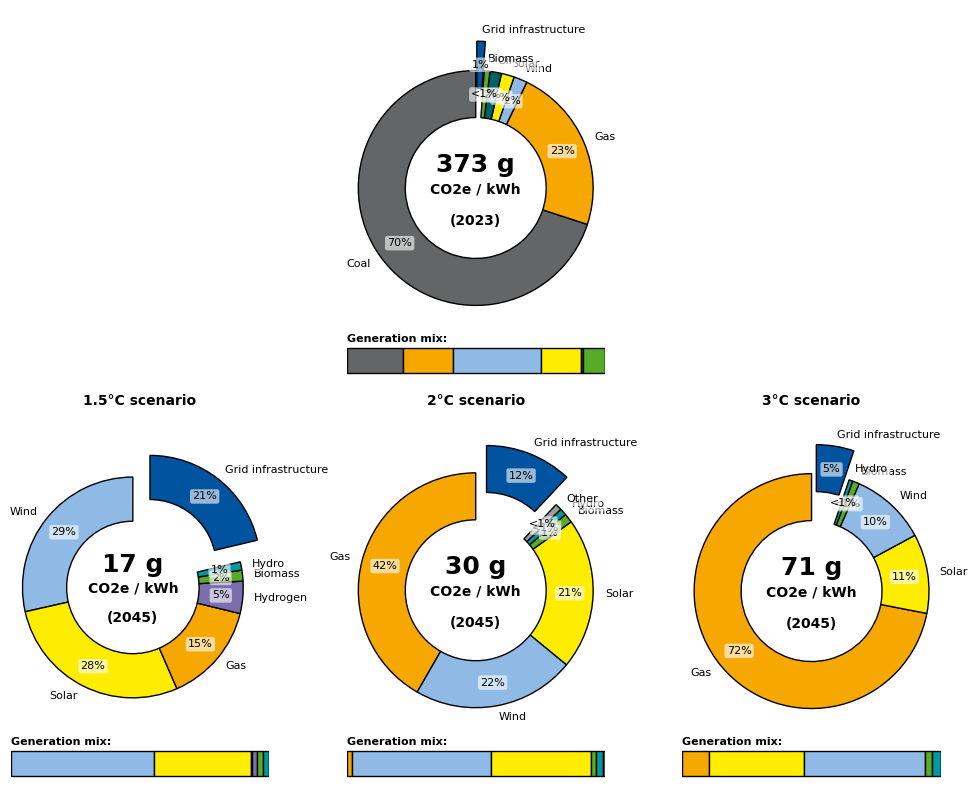

In [16]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams

import matplotlib.colors as mcolors

def process_input(data, grid_share):
    labels = []
    impacts = []
    generations = []

    other_impact = 0
    other_gen = 0

    total_impact = sum(impact for _, impact in data.values())
    total_gen = sum(gen for gen, _ in data.values())

    for k, (gen, impact) in data.items():
        impact_share = impact / total_impact
        gen_share = gen / total_gen

        if impact_share < 0.005 or gen_share < 0.005:
            other_impact += impact
            other_gen += gen
        else:
            labels.append(k.capitalize())
            impacts.append(impact)
            generations.append(gen)

    if total_impact > 0 and round((other_impact / total_impact) * 100) >= 1:
        labels.append("Other")
        impacts.append(other_impact)
        generations.append(other_gen)

    scale = (100 - grid_share) / sum(impacts)
    impacts = [i * scale for i in impacts]

    labels.append("Grid infrastructure")
    impacts.append(grid_share)
    generations.append(0)

    combined = list(zip(impacts[:-1], generations[:-1], labels[:-1]))
    combined.sort(reverse=True)

    impacts_sorted, generations_sorted, labels_sorted = zip(*combined)
    impacts_final = list(impacts_sorted) + [impacts[-1]]
    generations_final = list(generations_sorted) + [generations[-1]]
    labels_final = list(labels_sorted) + [labels[-1]]

    return labels_final, impacts_final, generations_final

def brighten(color, factor=0):
# def brighten(color, factor=0.4):
    rgb = mcolors.to_rgb(color)
    return tuple(min(1, c + (1 - c) * factor) for c in rgb)

labels_quo, impacts_quo, gens_quo = process_input(status_quo_generation, percentage_of_grid["statusquo"])
labels_650, impacts_650, gens_650 = process_input(remind_eu_ssp2_pkbudg650_generation, percentage_of_grid["PkBudg650"])
labels_1000, impacts_1000, gens_1000 = process_input(remind_eu_ssp2_pkbudg1000_generation, percentage_of_grid["PkBudg1000"])
labels_npi, impacts_npi, gens_npi = process_input(remind_eu_ssp2_npi_generation, percentage_of_grid["NPi"])

color_map = {
    "Grid infrastructure":cm.RWTHBlau.p(100),
    "Coal":"#646567",
    "Gas":cm.RWTHOrange.p(100),
    "Biomass": cm.RWTHGruen.p(100),
    "Wind": cm.RWTHBlau.p(50),
    "Geothermal": cm.RWTHBlau.p(50),
    "Solar":cm.RWTHGelb.p(100),
    "Hydro":cm.RWTHTuerkis.p(100),
    "Oil": cm.RWTHPetrol.p(100),
    "Hydrogen": cm.RWTHLila.p(100),
    "Nuclear": cm.RWTHGelb.p(100),
    "Other": cm.RWTHSchwarz.p(50),
}

def draw_donut(ax, sizes, labels, title, total, year):
    colors = [color_map[label] for label in labels]
    explode = [0.25 if label == "Grid infrastructure" else 0 for label in labels]
    bbox_props = dict(boxstyle="round,pad=0.2", ec="none", fc="white", alpha=0.6)

    ax.pie(
        sizes,
        radius=1,
        labels=labels,
        colors=colors,
        startangle=90,
        wedgeprops={"width": 0.4, "edgecolor": "black", "linewidth": 1},
        explode=explode,
        autopct=lambda pct: "<1%" if pct < 1 else f"{pct:.0f}%",
        pctdistance=0.8,
        textprops={
            "color": "black",
            "fontsize": 8,
            "bbox": bbox_props,
        },
    )

    ax.text(0, 0.2, f"{total} g", ha='center', va='center',
            fontsize=18, weight='bold', linespacing=1.5)
    ax.text(0, -0.01, f"CO2e / kWh", ha='center', va='center',
            fontsize=10, weight='bold', linespacing=1.5)
    ax.text(0, -0.28, f"({year})", ha='center', va='center',
        fontsize=10, weight='bold', linespacing=1.5)
    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.axis('equal')


def draw_stacked_bar(ax, gen_sizes, labels):
    colors = [brighten(color_map[label]) for label in labels]
    left = 0
    bbox_props = dict(boxstyle="round,pad=0.2", ec="none", fc="white", alpha=0.6)
    total = sum(gen_sizes)

    for size, color, label in zip(gen_sizes, colors, labels): #color in colors
        ax.barh(
            0, size, left=left,
            color=color, 
            edgecolor='black',
            linewidth=1, 
            height=0.0075, 
            # hatch="////",
        )
        left += size

    ax.set_xlim(0, total)
    ax.set_ylim(-0.005, 0.005)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)


fig, axes = plt.subplots(5, 3,
    figsize=(12, 10),
    gridspec_kw={'height_ratios': [3, 0.3, 0.2, 3, 0.3], 'hspace': 0.05, 'wspace': 0.3},
)

axes[0, 0].axis('off')
axes[0, 2].axis('off')
axes[1, 0].axis('off')
axes[1, 2].axis('off')
for ax in axes[2, :]:
    ax.axis('off')

draw_donut(axes[0, 1], impacts_quo, labels_quo, "", 373, 2023)
draw_stacked_bar(axes[1, 1], gens_quo, labels_quo)

draw_donut(axes[3, 0], impacts_650, labels_650, "1.5°C scenario", 17, 2045)
draw_donut(axes[3, 1], impacts_1000, labels_1000, "2°C scenario", 30, 2045)
draw_donut(axes[3, 2], impacts_npi, labels_npi, "3°C scenario", 71, 2045)

draw_stacked_bar(axes[4, 0], gens_650, labels_650)
draw_stacked_bar(axes[4, 1], gens_1000, labels_1000)
draw_stacked_bar(axes[4, 2], gens_npi, labels_npi)

axes[1, 1].set_title("Generation mix:", fontsize=8, fontweight="bold", pad=0, loc="left")
axes[4, 0].set_title("Generation mix:", fontsize=8, fontweight="bold", pad=0, loc="left")
axes[4, 1].set_title("Generation mix:", fontsize=8, fontweight="bold", pad=0, loc="left")
axes[4, 2].set_title("Generation mix:", fontsize=8, fontweight="bold", pad=0, loc="left")

plt.savefig("figs/Fig2.svg", format="svg", bbox_inches="tight")
plt.show()

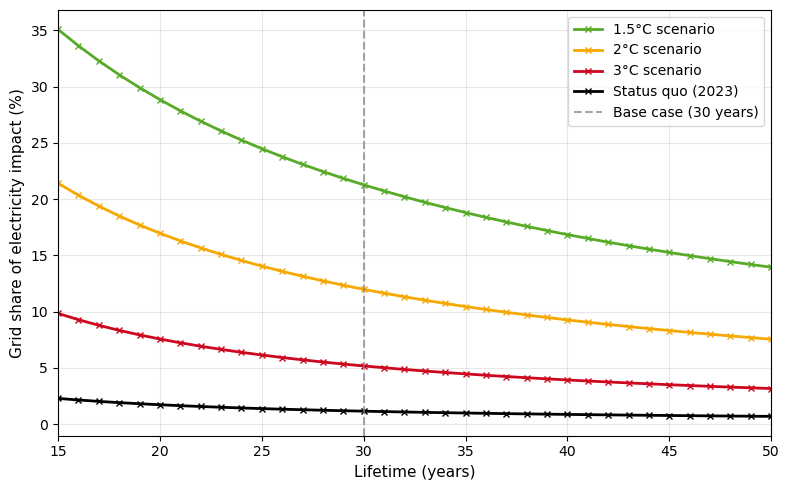

In [19]:
# Sensitivity analysis: Lifetime variation (20-50 years)
import numpy as np

lifetimes = np.arange(15, 51, 1)

sensitivity_results = {scenario: [] for scenario in ["statusquo", "static_expansion", "NPi", "PkBudg1000", "PkBudg650"]}

for lifetime in lifetimes:
    grid_impacts = {
        "statusquo": score_status_quo / lifetime / CONSUMPTION_2023,
        "static_expansion": (score_status_quo + score_static) / lifetime / CONSUMPTION_2045,
        "NPi": (score_status_quo + score_base) / lifetime / CONSUMPTION_2045,
        "PkBudg1000": (score_status_quo + score_PkBudg1000) / lifetime / CONSUMPTION_2045,
        "PkBudg650": (score_status_quo + score_PkBudg650) / lifetime / CONSUMPTION_2045,
    }
    
    total_impacts = {
        key: electricity_generation_impacts[key] + grid_impacts[key]
        for key in grid_impacts
    }
    
    percentage_grid = {
        key: grid_impacts[key] / total_impacts[key] * 100
        for key in grid_impacts
    }
    
    for scenario in sensitivity_results:
        sensitivity_results[scenario].append(percentage_grid[scenario])

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

scenario_labels = {
    "statusquo": "Status quo (2023)",
    "static_expansion": "Static expansion",
    "NPi": "3°C scenario",
    "PkBudg1000": "2°C scenario",
    "PkBudg650": "1.5°C scenario",
}

scenario_colors = {
    "statusquo": cm.RWTHSchwarz.p(100),
    "static_expansion": cm.RWTHSchwarz.p(50),
    "NPi": cm.RWTHRot.p(100),
    "PkBudg1000": cm.RWTHOrange.p(100),
    "PkBudg650": cm.RWTHGruen.p(100),
}

for scenario in ["PkBudg650", "PkBudg1000", "NPi", "statusquo"]:
    ax.plot(lifetimes, sensitivity_results[scenario], 
            label=scenario_labels[scenario], 
            color=scenario_colors[scenario],
            linewidth=2,
            marker="x",
            markersize=4,
            )

ax.axvline(x=30, color='gray', linestyle='--', alpha=0.7, label='Base case (30 years)')

ax.set_xlabel("Lifetime (years)", fontsize=11)
ax.set_ylabel("Grid share of electricity impact (%)", fontsize=11)
ax.set_xlim(15, 50)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figs/sensitivity_lifetime.svg", format="svg", bbox_inches="tight")
plt.show()